## goal: retrieve representation for data points from a pre-trained unsupervised VAE model.
## calculate number of active latent dimensions, and plot the distribution of mean and standard deviation from each dimension

In [20]:
# imports
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.compat.v1 import gfile
import pdb

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # CPU-only

sys.path.append(os.path.abspath("/home/mwu34/disentanglement_lib"))
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

In [14]:
# get the original dsprites dataset
from disentanglement_lib.data.ground_truth import named_data
dsprites = named_data.get_named_ground_truth_data('dsprites_full', -1)
random_state = np.random.RandomState(0)
factors, images = dsprites.sample(5, random_state)

In [28]:
# retrieve the representation associated with the dataset
def retrieve_representation(dataset, module_path, num_random_points, random=False):
    with hub.eval_function_for_module(module_path) as f:
        def _gaussian_encoder(x):
            """Encodes images using trained model."""
            # Push images through the TFHub module.
            output = f(dict(images=x), signature="gaussian_encoder", as_dict=True)
            # Convert to numpy arrays and return.
            return {key: np.array(values) for key, values in output.items()}
        if random:
            select_indices = random_state.choice(len(dataset.images), num_random_points, replace=False)
            images = np.expand_dims(dataset.images[select_indices], 3)
            representation_dict = _gaussian_encoder(images)
            
        else:  # retrieve representation of the entire dataset
            num_points_per_block = 10000
            num_blocks = int(np.ceil(len(dataset.images) / num_points_per_block))
            representation_list = [0] * num_blocks
            for block in range(num_blocks):
                start_idx = num_points_per_block * block
                images = np.expand_dims(dataset.images[start_idx: start_idx + num_points_per_block], 3)
                representation_list[block] = _gaussian_encoder(images)
            representation_dict = dict()
            print(representation_list[0].keys())
            # pdb.set_trace()
            for key in representation_list[0].keys():
                representation_dict[key] = np.concatenate([block[key] for block in representation_list], axis=0)
            
        representation_dict['std'] = np.exp(representation_dict['logvar'] / 2)
        return representation_dict

num_random_points = 10000
module_path = "/home/mwu34/disentanglement_lib/pretrained_unsupervised_study_v1/0/model/tfhub"
representation_dict = retrieve_representation(dsprites, module_path, -1, False)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


dict_keys(['mean', 'logvar'])


In [82]:
# get the datapoints with highest or lowest summed variance
# assume that we know the number of underlying FoVs, and we select the latent dimensions with smallest average std
def select_informative_points(representation_dict, num_FoVs, num_informative_points, selection_criterion, save=False):
    num_latent = representation_dict['std'].shape[1]
    mean_of_std = [np.mean(representation_dict['std'][:, latent]) for latent in range(num_latent)]
    std_thres = sorted(mean_of_std)[num_FoVs]
    selected_latent_indices = [latent for latent in range(num_latent) if mean_of_std[latent] < std_thres]
    summed_std = np.sum(representation_dict['std'][:, selected_latent_indices], axis=1)
    print(f"mean of std for each dimension is {mean_of_std}")
    print(f"indices of smallest mean of std: {selected_latent_indices}")
    if selection_criterion == 'highest_summed_std':
        thres = sorted(summed_std, reverse=True)[num_informative_points]
        informative_points = {k: summed_std[k] for k in range(len(summed_std)) if summed_std[k] > thres}
    elif selection_criterion == 'lowest_summed_std':
        thres = sorted(summed_std)[num_informative_points]
        informative_points = {k: summed_std[k] for k in range(len(summed_std)) if summed_std[k] < thres}
    else:
        raise ValueError("selection criterion not found")
    
    if save:
        save_path = os.path.join(
            os.environ.get("DISENTANGLEMENT_LIB_DATA", "."),
            "dsprites", f"{selection_criterion}_{num_informative_points}.pickle"
        )
        with open(save_path, 'wb') as handle:
            pickle.dump(informative_points, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(f'saved informative points to {save_path}')
    else:
        print('no save_path specified, not saving informative points')
    return informative_points


def index_to_factors(index_array, factor_bases):
    """transform dataset image indices to factors."""
    factor_bases = factor_bases.astype(int)
    factors = np.zeros((len(index_array), len(factor_bases) - 1))
    for factor_idx, factor_base in enumerate(factor_bases[1:]):
        factors[:, factor_idx], index_array = np.divmod(index_array, factor_base)
    return factors
        
# are informative points distributed evenly?
def plot_ground_truth_factor_hist(informative_factors, factor_sizes):
    """histogram on each ground truth FoV"""
    print(f"factor_size for each fov is {factor_sizes}")
    num_fov = len(factor_sizes)
    for fov in range(num_fov):
        plt.subplot(2, (num_fov+1) // 2, fov + 1)
        plt.hist(informative_factors[:, fov], range=[0, factor_sizes[fov] - 1])

In [84]:
num_informative_points = 1000
selection_criterion = 'lowest_summed_std' 
informative_points = select_informative_points(representation_dict, 5, num_informative_points, selection_criterion, save=True)
# informative_factors = index_to_factors(list(informative_points.keys()), dsprites.factor_bases)
# plot_ground_truth_factor_hist(informative_factors, dsprites.full_factor_sizes[1:])

mean of std for each dimension is [0.024907418, 0.16880596, 0.032234702, 0.056757, 0.17729816, 0.04911853, 0.10775903, 0.034903396, 0.209119, 0.054461338]
indices of smallest mean of std: [0, 2, 5, 7, 9]
saved informative points to /home/mwu34/disentanglement_lib/datasets/dsprites/lowest_summed_std_1000.pickle


dimension 1 should be informative
dimension 3 should be informative
dimension 4 should be informative
dimension 5 should be informative
dimension 6 should be informative
dimension 7 should be informative
dimension 8 should be informative
dimension 9 should be informative


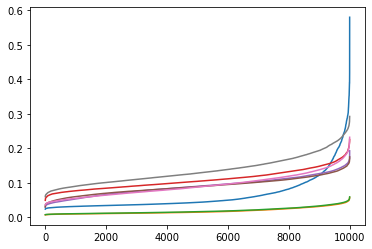

In [11]:
for i in range(10):
    mean_of_std = np.mean(representation_dict['std'][:, i])
    if mean_of_std < 0.3:
        plt.plot(sorted(representation_dict['std'][:, i]))
        print(f"dimension {i} should be informative")
# plt.legend(np.arange(10))
# print(sorted(np.mean(representation_dict['std'], 0)))

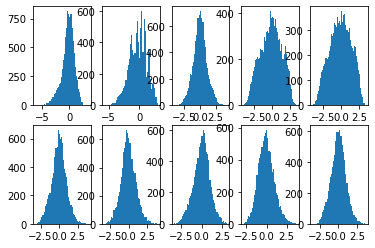

In [8]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.hist(representation_dict['mean'][:, i], bins=50)

dimension 0 is active, with std of mu 1.170
dimension 1 is active, with std of mu 1.421
dimension 2 is active, with std of mu 1.092
dimension 3 is active, with std of mu 1.445
dimension 4 is active, with std of mu 1.454
dimension 5 is active, with std of mu 0.977
dimension 6 is active, with std of mu 0.974
dimension 7 is active, with std of mu 0.985
dimension 8 is active, with std of mu 0.989
dimension 9 is active, with std of mu 0.966


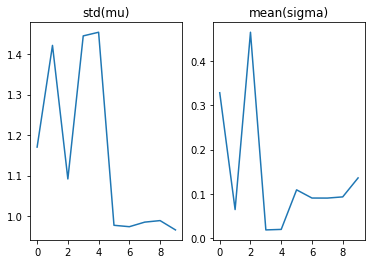

In [10]:
# draw figure
# for each dimension, calculate whether it is active or not
fig, axs = plt.subplots(1, 2)
axs[0].plot(np.arange(10), np.std(representation_dict['mean'], 0))
axs[0].set_title('std(mu)')
axs[1].plot(np.arange(10), np.mean(representation_dict['std'], 0))
axs[1].set_title('mean(sigma)')
for i in range(10):
    std_of_mean = np.std(representation_dict['mean'][:, i])
    if std_of_mean > 0.5:
        print(f"dimension {i} is active, with std of mu {std_of_mean:.3f}")
    else:
        print(f"dimension {i} is inactive, with std of mu {std_of_mean:.3f}")

In [21]:
# load tfhub after postprocessing for mean and sampled representation
module_path = "/home/mwu34/disentanglement_lib/pretrained_unsupervised_study_v1/0/postprocessed/mean/tfhub"
with hub.eval_function_for_module(module_path) as f:
    def _representation_function(x):
        """Computes representation vector for input images."""
        output = f(dict(images=x), signature="representation", as_dict=True)
        return np.array(output["default"])
    gg = _representation_function(images)
    print(gg.shape)
    print(gg)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


(5, 10)
[[ 1.288534   -1.4352859   0.0042002  -0.5812464   0.53785264 -0.3958643
  -1.508388    0.39641657 -0.72962546  1.5703562 ]
 [ 0.5888102   0.22784255 -0.4230413   0.1418778   1.2193228   0.77970386
   0.72105145 -1.3141254  -0.4800512  -2.932123  ]
 [ 0.4405732   1.348196    1.239087    1.859676    0.27003914 -0.5283151
   0.19695458  0.6522385   0.33971283 -0.02828822]
 [ 1.0429925  -1.3933804   1.694776   -0.02910801 -0.14538997  0.3383915
  -1.4434935  -0.28672796 -1.0276875  -0.18718232]
 [ 0.9223475  -2.4617329  -0.08861076  1.2551376   0.04523423  1.1659943
  -1.3360114  -1.5456886  -1.4465183  -0.17778702]]
